In [ ]:
# Set the time span of interest
# Read station file to parse the coordinates of stations
# Iterate over L2 products to extract chl-a values at stations
# Add chl-a value to a table with stations/dates
# Plot or produce data output

In [ ]:
# https://stackoverflow.com/questions/52293759/snappy-wrong-conversion-from-pixel-to-lat-long
# https://forum.step.esa.int/t/extracting-pixel-values-sentinel-2a-l2a-with-snap-or-snappy/29878/4

In [1]:
import os
import zipfile
import numpy as np
from PIL import Image
from datetime import date
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
from datetime import date, timedelta
import shutil
import pandas as pd
import seaborn as sns


from snappy import ProductIO, GPF, HashMap, ProductUtils, PixelPos, GeoPos, ProductData, jpy
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt, make_path_filter

%matplotlib inline

INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
Currently installed 9.0.0, available is 10.0.0.
Please visit http://step.esa.int



In [2]:
S3_ROOT_FOLDER = Path('/home/jovyan/earth-observations/notebooks')
ROI = 'indre-oslofjord'

START_DATE = date(2024, 3, 18)
END_DATE = date(2024, 3, 23)

STATIONS_FOLDER = S3_ROOT_FOLDER / 'stations'
STATIONS_FILENAME = 'stations_indre_oslofjord.csv'

In [3]:
def coords_from_xy(geocode, x, y):
    geoPos = geocode.getGeoPos(PixelPos(x, y), None)
    lat = geoPos.getLat()
    lon = geoPos.getLon()
    
    return lat, lon

def xy_from_coords(geocode, lat, lon):
    pixelPos = geocode.getPixelPos(GeoPos(lat, lon), None)
    x = np.round(pixelPos.getX())
    y = np.round(pixelPos.getY())
    
    return x, y

In [4]:
def get_chl_from_lat_lon(product, lat, lon):
    
    # print(list(product.getBandNames()))
    
    sg = product.getSceneGeoCoding()
    try:
        x, y = xy_from_coords(sg, lat, lon)
    except ValueError:
        print("Coordinates are outside the region of interest")
        return
    
    try:
        raw_chl_value = product.getBand('iop_apig').readPixels(int(x), int(y), 1, 1, np.zeros(1))
    except ValueError:
        print("Encountered a problem reading a pixel")
        return [0]
            
    return np.power(raw_chl_value, 1.04) * 21  # Default values from SNAP

In [7]:
def read_BEAM(filename):
    reader = ProductIO.getProductReader('BEAM-DIMAP')
    return ProductIO.readProduct(str(filename))


def start_processing(start_date, end_date):
    
    df_stations = pd.read_csv(STATIONS_FOLDER / STATIONS_FILENAME)
    columns = ['station', 'station_name', 'lat', 'lon', 'year', 'month', 'day', 'chl-a', 'source', 'twin']
    df = pd.DataFrame(columns=columns)     # Create an empty DataFrame with the specified columns
    
    delta = end_date - start_date
    
    # Iterate over each day in the range
    for i in range(delta.days + 1):
        
        for twin in ["A", "B"]: # Sentinel 3 (A or B)
        
            current_date = start_date + timedelta(days=i)

            # Extract metadata from the filename
            year, month, day =  str(current_date.year), current_date.strftime('%B'), str(current_date.day)

            source_folder = S3_ROOT_FOLDER / 'S3' / 'L2' / ROI / year / month / day / 'C2RCC' / f'S3{twin}.dim'

            try:
                # read L2 products one by one and iterate over the stations to extract the pixel value at a specified (latitude, longitude) pair
                product = read_BEAM(source_folder)
                
                for index, row in df_stations.iterrows():

                    new_row = pd.Series({'station': row['station'], 
                                         'station_name': row['station_name'], 
                                         'lat': row['latitude'], 
                                         'lon': row['longitude'], 
                                         'year': year,
                                         'month': month,
                                         'day': day,
                                         'chl-a': get_chl_from_lat_lon(product, row['latitude'], row['longitude'])[0],
                                         'source': 'satellite',
                                         'twin': twin})

                    df = pd.concat([df, new_row.to_frame().T], ignore_index=True)
                    
                print(f"{source_folder} done!")

            except RuntimeError:
                print(f"{source_folder} does not exist. Skipping...")

    print("Done!")

    return df


In [8]:
satellite_df = start_processing(date(2024, 3, 1), date(2024, 3, 30))

/home/jovyan/earth-observations/notebooks/S3/L2/indre-oslofjord/2024/March/1/C2RCC/S3A.dim done!
/home/jovyan/earth-observations/notebooks/S3/L2/indre-oslofjord/2024/March/1/C2RCC/S3B.dim done!
Encountered a problem reading a pixel
Encountered a problem reading a pixel
/home/jovyan/earth-observations/notebooks/S3/L2/indre-oslofjord/2024/March/2/C2RCC/S3A.dim done!
/home/jovyan/earth-observations/notebooks/S3/L2/indre-oslofjord/2024/March/2/C2RCC/S3B.dim done!
/home/jovyan/earth-observations/notebooks/S3/L2/indre-oslofjord/2024/March/3/C2RCC/S3A.dim does not exist. Skipping...
/home/jovyan/earth-observations/notebooks/S3/L2/indre-oslofjord/2024/March/3/C2RCC/S3B.dim does not exist. Skipping...
/home/jovyan/earth-observations/notebooks/S3/L2/indre-oslofjord/2024/March/4/C2RCC/S3A.dim does not exist. Skipping...
/home/jovyan/earth-observations/notebooks/S3/L2/indre-oslofjord/2024/March/4/C2RCC/S3B.dim does not exist. Skipping...
/home/jovyan/earth-observations/notebooks/S3/L2/indre-oslofj

In [9]:
satellite_df.shape

(592, 10)

In [10]:
satellite_df

,station,station_name,lat,lon,year,month,day,chl-a,source,twin
0,Ap1,Frognerkilen,59.909017,10.701133,2024,March,1,4.021201,satellite,A
1,Ap2,Kavringen,59.899,10.718,2024,March,1,0.0,satellite,A
2,Ap3,Skurven,59.89805,10.70103,2024,March,1,4.497154,satellite,A
3,Ap4,Tjuvholmen,59.9083,10.7192,2024,March,1,4.503184,satellite,A
4,Aq1,Oslo havn,59.90895,10.730433,2024,March,1,0.0,satellite,A
...,...,...,...,...,...,...,...,...,...,...
587,Hm6,Drøbakterskelen,59.667683,10.615784,2024,March,23,6.639831,satellite,B
588,Im1,Drøbak sør,59.6563,10.6217,2024,March,23,6.403588,satellite,B
589,Im2,Elle,59.622032,10.628217,2024,March,23,7.188723,satellite,B
590,Im3,Drøbak havn,59.6607,10.6217,2024,March,23,6.308419,satellite,B


<AxesSubplot: xlabel='day', ylabel='chl-a'>

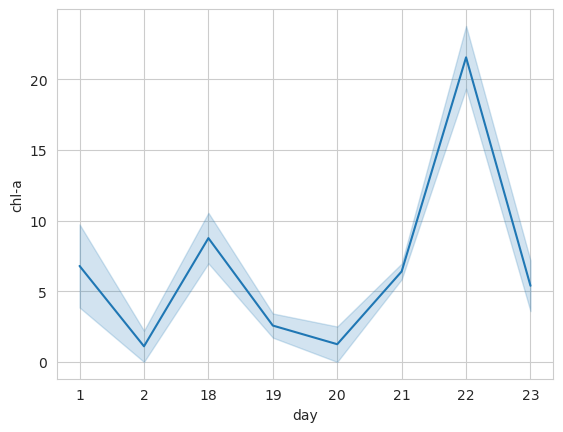

In [12]:
sns.set_style("whitegrid")
sns.lineplot(x="day", y="chl-a", data = satellite_df[satellite_df["station"] == "Im2"])

## Other

In [53]:
def plotBand(product, band):
     
    band = product.getBand(band)

    w = band.getRasterWidth()
    h = band.getRasterHeight()

    band_data = np.zeros(w * h, np.float32)
    band.readPixels(0, 0, w, h, band_data)

    band_data.shape = h, w

    width = 12
    height = 12
    plt.figure(figsize=(width, height))
    imgplot = plt.imshow(band_data, cmap=plt.cm.binary)
    
    return  

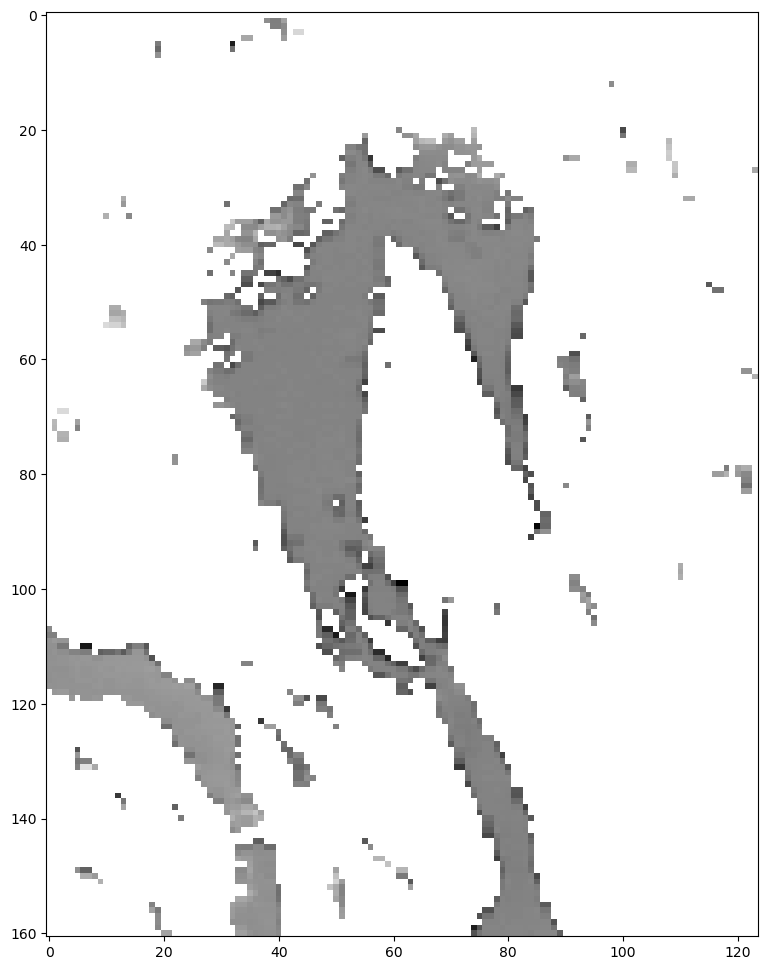

In [54]:
plotBand(product, 'iop_apig')